<a href="https://colab.research.google.com/github/moka-co/twitter_emo_classification/blob/main/emotion_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tweet Emotion Classification

Emotion Classification is a multi-label text classification task

Dataset used for this tasks and information about where they came from can be found on this project Github Repository: clone https://github.com/moka-co/twitter_emo_classification.git

# Environment Setup

In [1]:
import torch
import torch.nn as nn
import datasets
import pandas as pd
import random
import os
from collections import Counter
import re

# Data Acquisition

In [2]:
# Clone the repo
if not os.path.exists("twitter_emo_classification"):
  !git clone https://github.com/moka-co/twitter_emo_classification.git
  %cp twitter_emo_classification/data/* .

In [3]:
dataset = pd.read_pickle("merged_training.pkl")

In [4]:
# Get Glove embeddings
if not os.path.exists("glove.6B.zip"):
  print("🚀 Starting GloVe download...")
  !wget -q http://nlp.stanford.edu/data/glove.6B.zip
  !unzip glove.6B.zip > /dev/null 2>&1 &
  print("Finished GloVe download")


# Function that defines a glove embeddings matrix
def load_glove_embeddings(path, word2idx, embedding_dim=100):
    """
    path: path to glove.6B.100d.txt
    word2idx: dictionary mapping words to integers from your dataset
    """
    vocab_size = len(word2idx)
    # Initialize matrix with random values (or zeros)
    embedding_matrix = torch.randn(vocab_size, embedding_dim)

    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            if word in word2idx:
                vector = torch.tensor([float(x) for x in values[1:]])
                idx = word2idx[word]
                embedding_matrix[idx] = vector

    return embedding_matrix

In [5]:
# Download nltk tokenizer
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer

nltk.download('punkt_tab')



[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [6]:
dataset2 = None

if not os.path.exists("SemEval2018-Task1-all-data.zip"):
  !wget -q https://saifmohammad.com/WebDocs/AIT-2018/AIT2018-DATA/SemEval2018-Task1-all-data.zip
  !unzip -q SemEval2018-Task1-all-data.zip
  !rm -r __MACOSX/

sem_eval_path_train = "/content/SemEval2018-Task1-all-data/English/E-c/2018-E-c-En-train.txt"
sem_eval_path_val = "/content/SemEval2018-Task1-all-data/English/E-c/2018-E-c-En-test-gold.txt"

dict_semeval_columns = ['tweet_id','text','anger', 'anticipation', 'disgust', 'fear', 'joy',
    'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'
]

dataset2 = pd.read_csv(sem_eval_path_train,
        sep='\t',
        header=0,
        names=dict_semeval_columns
    )

In [7]:
dataset2.head()

,tweet_id,text,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-En-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-En-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-En-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-En-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-En-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


I'm going to merge the two dataset together. As criteria, i'm selecting only the rows from the dataset 2 that are compatible with dataset 1 i.e rows labeled with 1 only if the label is present in the first set of labels.

First i want to check if there are any duplicates i.e text contained in both dataset

In [8]:
# Check duplicates
duplicates = [dataset2["text"].isin(dataset["text"])]
print(f"Duplicates: {len(duplicates)}")

Duplicates: 1


In [9]:
# Merge dataset2 with dataset 1
df = dataset
emotion_to_id = dict(enumerate(df['emotions'].astype('category').cat.categories))

# Filter rows
def filter_rows(target_df, emotion_mapping):
    """
    Returns rows where none of the specified emotions are present (all 0s).
    """
    # Extract the emotion names from your dictionary
    target_emotions = list(emotion_mapping.values())

    # Filter only the columns that actually exist in the dataframe to avoid KeyErrors
    existing_cols = [col for col in target_emotions if col in target_df.columns]

    # Sum the emotion columns value horizontally (axis=1) and keep rows where the sum is 0
    mask = target_df[existing_cols].sum(axis=1) == 0
    negative_df = target_df[mask].copy()

    print(f"✅ Filtered {len(negative_df)} rows out of {len(target_df)}")
    return negative_df

negative = filter_rows(dataset2, emotion_to_id) # Dataset containing only rows with label not present in dataset1

# take only compatible rows:
positive = dataset2[~dataset2.index.isin(negative.index)]

# Create semeval_subset directly from positive text
semeval_subset = pd.DataFrame({
    'text': positive['text'].values
}, index=positive.index)

# 2. Identify which columns in 'positive' map to our target emotions
alignment_map = {
'anger': 'anger',
'fear': 'fear',
'joy': 'joy',
'love': 'love',
'sadness': 'sadness',
'surprise': 'surprise',
'disgust': 'anger' # Common academic grouping: Disgust often maps to Anger
}

present_cols = [col for col in alignment_map.keys() if col in positive.columns]

semeval_subset['emotions'] = positive[present_cols].any(axis=1).astype(int)
def map_to_primary(row):
    for col in present_cols:
        if row[col] == 1:
            return alignment_map[col]


semeval_subset['emotions'] = positive.apply(map_to_primary, axis=1)

✅ Filtered 591 rows out of 6838


In [10]:
# Visualize that now it has the desired structure
semeval_subset.head()

,text,emotions
1,Whatever you decide to do make sure it makes y...,joy
2,@Max_Kellerman it also helps that the majorit...,anger
3,Accept the challenges so that you can literall...,joy
4,My roommate: it's okay that we can't spell bec...,anger
5,No but that's so cute. Atsu was probably shy a...,joy


In [11]:
df.head()

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love


In [12]:
# Merge the two datasets
merged_dataset = pd.concat([dataset, semeval_subset], ignore_index=True)
merged_dataset.describe()

,text,emotions
count,423056,423056
unique,400068,6
top,i feel more adventurous willing to take risks,joy
freq,16,143185


# Preprocessing Pipeline
TODO:
**Tokens**: for now i consider tokens as: alphanumeric words divided by white spaces without counting puntutation.


In [184]:
import string

class PreprocessPipeline:
  def __init__(self):
    self.tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)

    # List of chars to keep
    # point is keep for elipses "..."
    chars_to_keep = "@#?!.'"
    self.punct_to_remove = "".join([c for c in string.punctuation if c not in chars_to_keep])

  def clean_text(self, text):
    # Lower
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\b(href|http|https)\b', '', text)

    # Some noise patterns found
    noise_patterns = [
        r'gt',
        # This version catches "class delicious", "class-delicious", or "class=delicious"
        r'class[^\w\s]*delicious[^\w\s]*title[^\w\s]*share[^\w\s]*del', # Removes 'gt' (from >)
        r'rel[^\w\s]*nofollow[^\w\s]*target[^\w\s]*blank',              # Specific CSS/HTML string
        r'languagedirection[^\w\s]*ltr',                                 # Specific CSS/HTML string
        r'\b(type|application|atom|xml|feedlinks|href|http|https)\b',     # Directional metadata
    ]

    noise_patterns = [
        r'\bgt\b',
        r'class delicious title share del',
        r'\b(type|application|atom|xml)\b',
        r'rel nofollow target blank',                   # Link attributes
        r'feedlinks',                                   # Feed links
        r'languagedirection ltr'                        #
    ]
    combined_noise = '|'.join(noise_patterns)
    text = re.sub(combined_noise, '', text)

    # Remove puntuation, keep some special characters
    # We use a translation table here; it's much faster than regex for single characters
    table = str.maketrans('', '', self.punct_to_remove)
    text = text.translate(table)

    text = re.sub(combined_noise, '', text) # re apply

    # Remove extra space
    text = re.sub(r'\s+', ' ', text).strip()
    return text

  def transform(self, text):
    text = self.clean_text(text)
    tokens = self.tweet_tokenizer.tokenize(text)
    return tokens

# Exploratory Data Analysis
We have a total of 423k labeled samples with four 6 emotions

In [158]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [159]:
df = merged_dataset

In [160]:
print(pd.unique(df['emotions']))

['sadness' 'joy' 'love' 'anger' 'fear' 'surprise']


I add a label for each emotion for making data easier to works with

In [161]:
id_to_emotion = {0: 'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
emotion_to_id = {'sadness':0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}
df['label_id'] = df['emotions'].map(emotion_to_id)

df.head()

,text,emotions,label_id
0,i feel awful about it too because it s my job to get him in a position to succeed and it just didn t happen here,sadness,0
1,im alone i feel awful,sadness,0
2,ive probably mentioned this before but i really do feel proud of myself for actually keeping up with my new years resolution of monthly and weekly goals,joy,1
3,i was feeling a little low few days back,sadness,0
4,i beleive that i am much more sensitive to other peoples feelings and tend to be more compassionate,love,2


In [162]:
# Custom colors for emotions
custom_palette = {
    'anger': '#FF4B4B',    # Red
    'joy': '#228B22',       # Forest Green
    'sadness': '#1E90FF',  # Blue
    'fear': '#800080',     # Purple
    'love': '#FF69B4',     # Pink
    'surprise': '#FFA500'  # Orange
}

Text(0.5, 1.0, 'Distribution of Emotions')

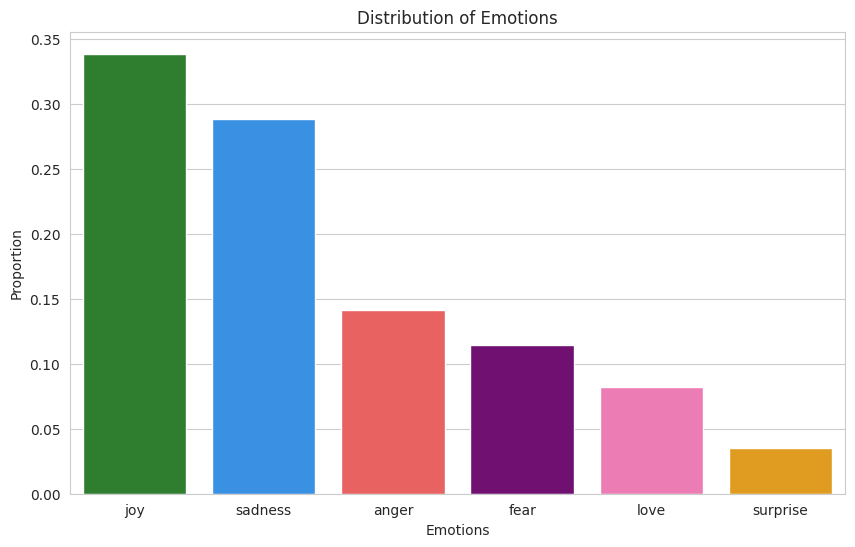

In [163]:
# Compute proportions
distributions=df['emotions'].value_counts(normalize=True)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.countplot(data=df, x='emotions', order = distributions.index, palette=custom_palette, hue='emotions', legend=False,stat='proportion')
plt.xlabel('Emotions')
plt.ylabel('Proportion')
plt.title('Distribution of Emotions')

We notice that data is unbalanced:
- About 0.65 of samples are joy or sadness
- Surprise is the class with the lowest samples

## Text Analysis
Since dataset is composed of textual data, it is insightful to make some analysis.

First i apply the Preprocessing Pipeline previously defined to extract tokens.
Then i compute some common statistics for **tweet length**
- mean
- standard deviation
- median
- longest and shortest tweets

In [185]:
# Extract all words
pipeline = PreprocessPipeline()
postprocess_df = df['text'].apply(lambda x : pipeline.clean_text(x))
df['text'] = postprocess_df

all_words = []
all_tweets_length = []
for tweet in df['text']:
  tokens = pipeline.transform(tweet)
  all_words.extend(tokens)
  all_tweets_length.append(len(tokens))

mean_tweets = np.mean(all_tweets_length)
median_tweets = np.median(all_tweets_length)
max_tweet = np.max(all_tweets_length)
min_tweet = np.min(all_tweets_length)
std_tweets = np.std(all_tweets_length)

original_std = std_tweets

/tmp/ipython-input-1662662445.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = postprocess_df


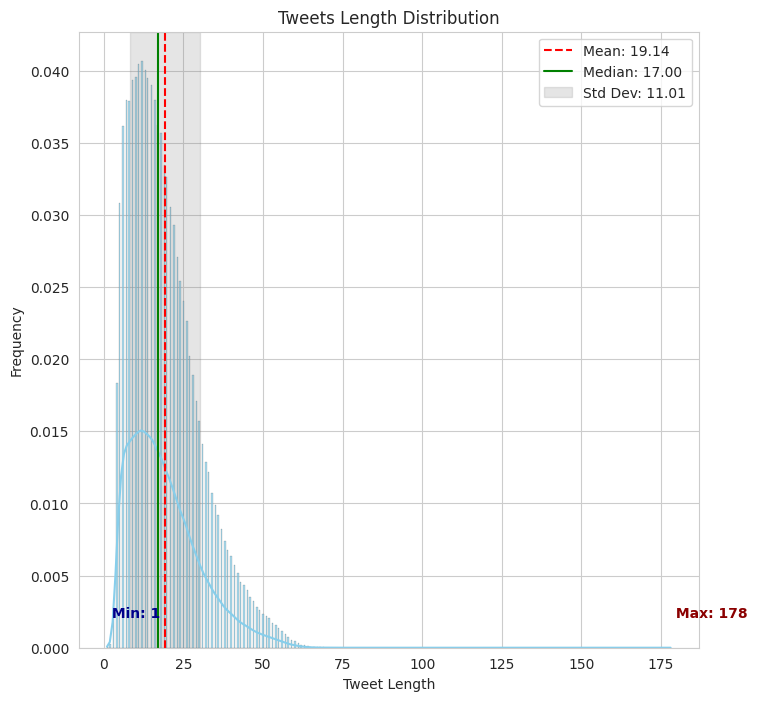

In [165]:
plt.figure(figsize=(8, 8))
sns.set_style("whitegrid")
sns.histplot(all_tweets_length, kde=True, color='skyblue', edgecolor='black', alpha=0.7, stat='proportion')
plt.axvline(mean_tweets, color='red', linestyle='--', label=f'Mean: {mean_tweets:.2f}')
plt.axvline(median_tweets, color='green', linestyle='-', label=f'Median: {median_tweets:.2f}')
plt.axvspan(mean_tweets - std_tweets, mean_tweets + std_tweets,
            color='grey', alpha=0.2, label=f'Std Dev: {std_tweets:.2f}')
plt.text(max_tweet, plt.ylim()[1]*0.05, f' Max: {max_tweet}', color='darkred', fontweight='bold')
plt.text(min_tweet, plt.ylim()[1]*0.05, f' Min: {min_tweet}', color='darkblue', fontweight='bold')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.title('Tweets Length Distribution')
plt.legend()

The mean tweet is 19.21 tokens long. The median is at the left of the mean, making the distribution right skeewed because most users write short tweets.

**Padding**: for this task i'm gonna use a tokenizer, choosing a max_len too high is inconvenient if most of the data falls between 0 and 75.

**Outliers**: the distribution has a long tail, but the tweets with >70 lengths have a low frequency, hence may be potential outliers.

Next i'm gonna plot the boxplot of the data.
A box plot shows the distribution of quantitative data in a way that facilitates comparisons between classes (in this case, emotion)

Text(0.5, 1.0, 'Boxplot of Tweet Length by Emotion')

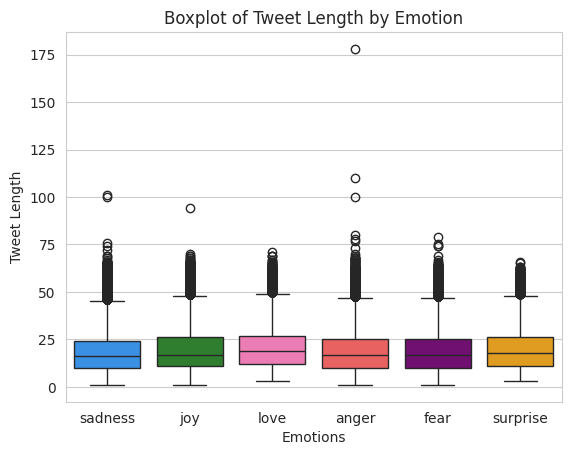

In [166]:
sns.boxplot(x="emotions",
            y=all_tweets_length,
            data=df,
            palette=custom_palette,
            hue='emotions')
plt.xlabel('Emotions')
plt.ylabel('Tweet Length')
plt.title('Boxplot of Tweet Length by Emotion')

There is no substantial differences for tweet length across different emotions.

For instance, if we consider as outliers greater with a length greater than than 75 tokens, the affected classes would be 'sadness', 'anger' and 'fear'.



## N-Gram Analysis
Analyizing n-gram could help see what words occurs most often for each class.

ONLY for N-Gram anlysis, i'll remove stop words.

In [167]:

from nltk import ngrams
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english')) # I remove stop words
print(stop_words)

{"weren't", "she's", 'if', 'itself', "i'd", 'here', 'of', 'has', 's', "you'd", 'most', 'over', "they'd", "haven't", "i'll", 'have', 'there', 'by', 'but', 'weren', 'very', "it'll", 'after', 'wouldn', "should've", 'him', 'it', 'which', 'doesn', 'ain', 'did', "they'll", "hadn't", "shan't", 'to', "you're", 'only', 'theirs', 'for', 'than', 'he', 'just', 'the', 'so', "he's", 'is', 'then', 'shouldn', 're', "needn't", 'during', 'i', 'not', 'up', 'again', "it's", 'further', 'between', 'its', "they're", 'same', 'doing', "isn't", "hasn't", 'because', 'll', 'am', 'more', 'whom', 'once', 'an', 'needn', 'in', 'such', "wasn't", 'do', 'nor', 'himself', 'o', 'against', 'or', 'she', 'out', 'hadn', 'with', "won't", 'few', 'don', "she'd", 'mightn', 'both', 'will', 'other', "wouldn't", 'why', 'while', 'our', 'a', 'how', "that'll", 'your', 'couldn', "we've", 'ma', 'ourselves', 'their', 'my', 'at', 'yours', 'any', 'be', 'didn', 'below', 'we', 'hasn', 'were', "couldn't", 'you', 'and', 'are', "mustn't", 've', 

Stop words are common english words and contractions. Some of these like "the" don't provide much insight about data but they are very frequent. So i remove them.

## Most Frequent Unigram
In this section i'll compute most frequent unigram that coincide with most frequent words

Text(0, 0.5, '')

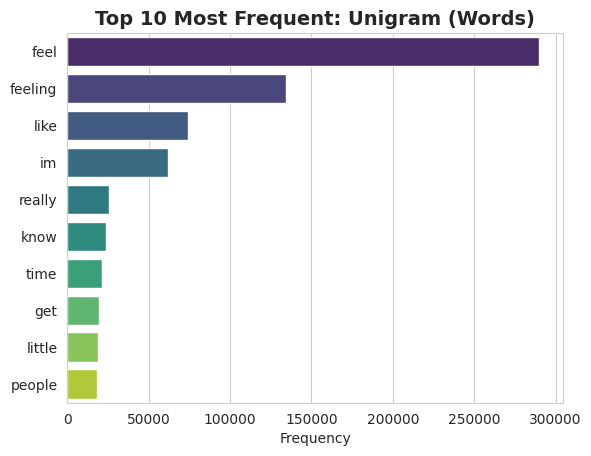

In [168]:
# Most Frequent Unigram
# 1. Get unigrams
all_unigrams = [
    word for text in df['text']
    for word in nltk.word_tokenize(str(text).lower())
    if word.isalnum() and word not in stop_words
]

# 2. Count the most common words
counts = Counter(all_unigrams).most_common(10)
words, freq = zip(*counts)

# Setup the Figure BEFORE plotting
sns.set_style("whitegrid")

# 4. Plot
ax = sns.barplot(
    x=list(freq),
    y=list(words),
    hue=list(words),
    palette='viridis',
    legend=False
)

# 5. Styling & Cleanup

plt.title(f'Top 10 Most Frequent: Unigram (Words)', fontsize=14, fontweight='bold')
plt.xlabel('Frequency')
plt.ylabel('')

"feel" and "feeling" are two words that are very frequent in the text. This **probably reflects how data was collected**, by selecting tweets that contains words like "feel" and "feeling".

In this way it's easy to collect tweets that may contains information like "i feel devastated" or "i feel angry" and associated "angry" and "sad" to emotional states.

## Most frequent Bi-grams and Trigrams
Now i'll compute most frequent

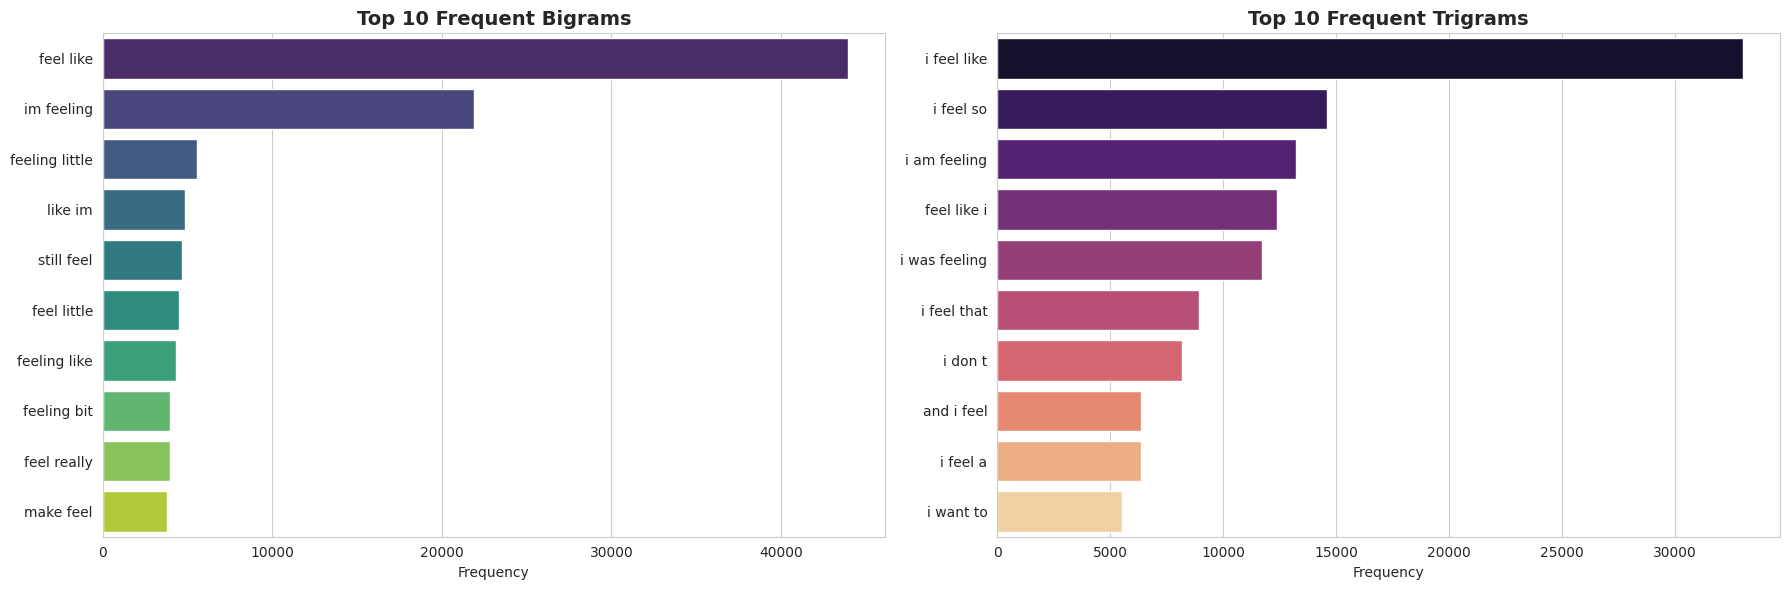

In [169]:
# Process Bigrams
all_bigrams = []

for text in df['text']:
    tokens = nltk.word_tokenize(str(text).lower())
    filtered_tokens = [t for t in tokens if t.isalnum() and t not in stop_words]
    if len(filtered_tokens) >= 2:
        all_bigrams.extend(list(ngrams(filtered_tokens, 2)))


counts_bi = Counter(all_bigrams).most_common(10)
words_bi = [' '.join(w) for w, f in counts_bi]
freq_bi = [f for w, f in counts_bi]

# Process Trigrams
all_trigrams = []
for text in df['text']:
    tokens = nltk.word_tokenize(str(text).lower())
    all_trigrams.extend(list(ngrams(tokens, 3)))

counts_tri = Counter(all_trigrams).most_common(10)
words_tri = [' '.join(w) for w, f in counts_tri]
freq_tri = [f for w, f in counts_tri]

# Create a figure with 1 row and 2 columns, wide enough for text
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.set_style("whitegrid")

# --- Left Plot: Bigrams ---
sns.barplot(
    x=freq_bi,
    y=words_bi,
    hue=words_bi,
    palette='viridis',
    legend=False,
    ax=axes[0]  # This places it in the first (left) slot
)
axes[0].set_title('Top 10 Frequent Bigrams', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Frequency')

# --- Right Plot: Trigrams ---
sns.barplot(
    x=freq_tri,
    y=words_tri,
    hue=words_tri,
    palette='magma', # Used a different palette to visually distinguish
    legend=False,
    ax=axes[1]  # This places it in the second (right) slot
)
axes[1].set_title('Top 10 Frequent Trigrams', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Frequency')

# Adjust layout to prevent overlapping labels
plt.tight_layout()
plt.show()

## Most frequent 4- and 5- Grams

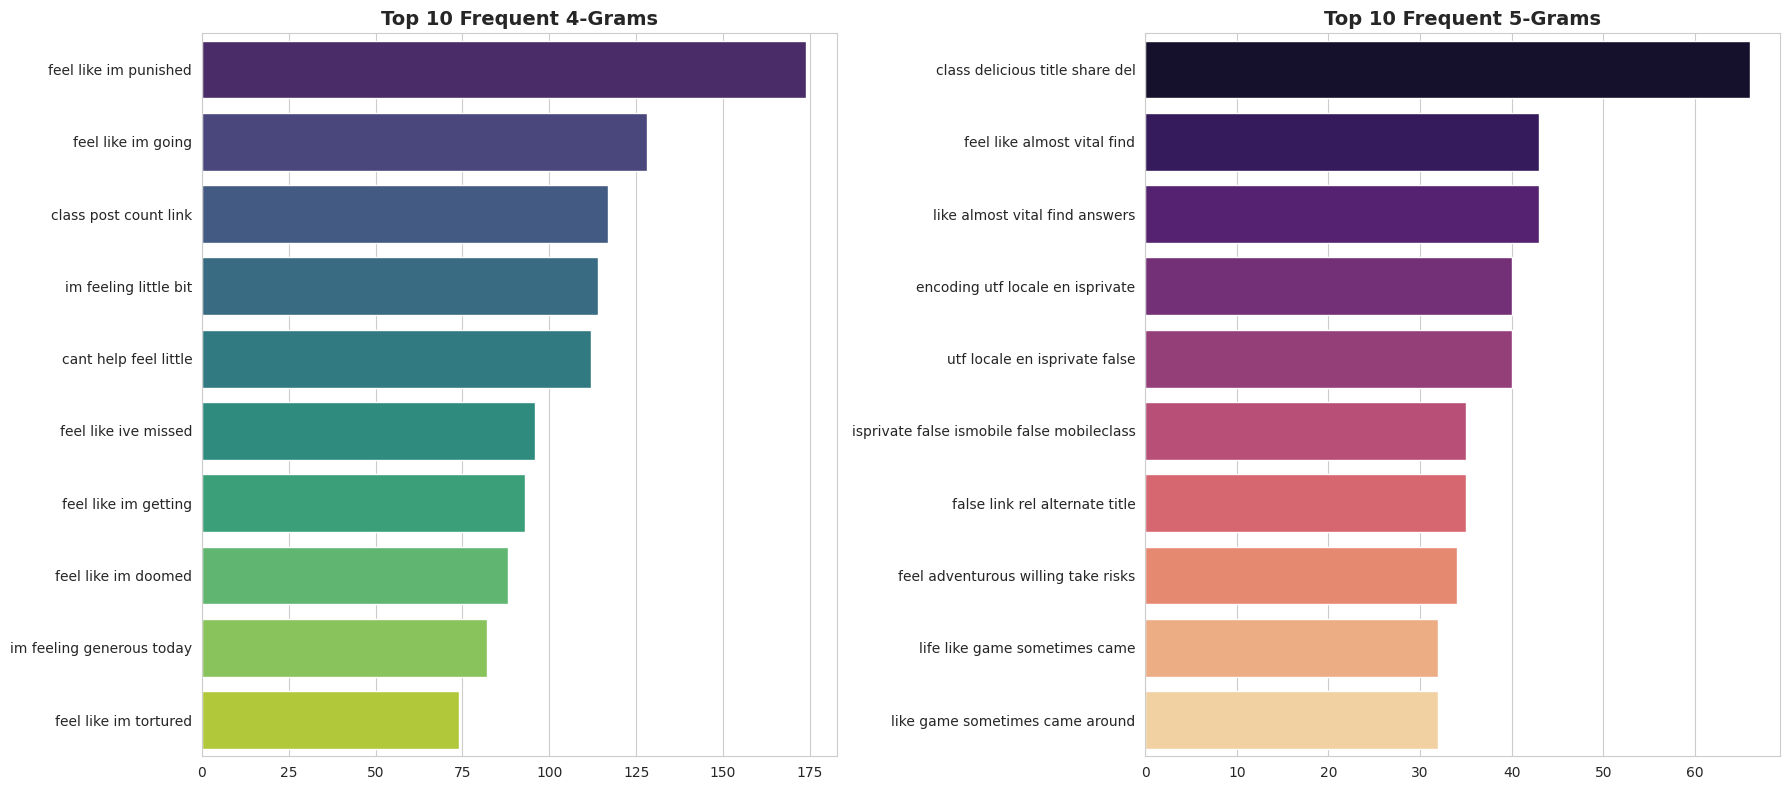

In [187]:
# --- Process 4-Grams ---
all_4grams = []
for text in df['text']:
    tokens = nltk.word_tokenize(str(text).lower())
    filtered_tokens = [t for t in tokens if t.isalnum() and t not in stop_words]
    if len(filtered_tokens) >= 4:
        all_4grams.extend(list(ngrams(filtered_tokens, 4)))

counts_four = Counter(all_4grams).most_common(10)
words_four = [' '.join(w) for w, f in counts_four]
freq_four = [f for w, f in counts_four]

# --- Process 5-Grams ---
all_5grams = []
for text in df['text']:
    tokens = nltk.word_tokenize(str(text).lower())
    filtered_tokens = [t for t in tokens if t.isalnum() and t not in stop_words]
    if len(filtered_tokens) >= 5:
        all_5grams.extend(list(ngrams(filtered_tokens, 5)))

counts_five = Counter(all_5grams).most_common(10)
words_five = [' '.join(w) for w, f in counts_five]
freq_five = [f for w, f in counts_five]

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.set_style("whitegrid")

# Left Plot: 4-Grams
sns.barplot(x=freq_four, y=words_four, hue=words_four, palette='viridis', legend=False, ax=axes[0])
axes[0].set_title('Top 10 Frequent 4-Grams', fontsize=14, fontweight='bold')

# Right Plot: 5-Grams
sns.barplot(x=freq_five, y=words_five, hue=words_five, palette='magma', legend=False, ax=axes[1])
axes[1].set_title('Top 10 Frequent 5-Grams', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

Top 10 most frequent 5 and 4-grams were useful to find some noise in the data.

N-Gram comparison between classes.
- Stop words are deleted
- I removed "feel like" because it is a neutral cue

In [202]:
from nltk.corpus import stopwords

# Compute subsets
df_sadness = df[df['emotions'] == 'sadness']
df_joy = df[df['emotions'] == 'joy']
df_love = df[df['emotions'] == 'love']
df_anger = df[df['emotions'] == 'anger']
df_fear = df[df['emotions'] == 'fear']
df_surprise = df[df['emotions'] == 'surprise']

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print(stop_words)

{"weren't", "she's", 'if', 'itself', "i'd", 'here', 'of', 'has', 's', "you'd", 'most', 'over', "they'd", "haven't", "i'll", 'have', 'there', 'by', 'but', 'weren', 'very', "it'll", 'after', 'wouldn', "should've", 'him', 'it', 'which', 'doesn', 'ain', 'did', "they'll", "hadn't", "shan't", 'to', "you're", 'only', 'theirs', 'for', 'than', 'he', 'just', 'the', 'so', "he's", 'is', 'then', 'shouldn', 're', "needn't", 'during', 'i', 'not', 'up', 'again', "it's", 'further', 'between', 'its', "they're", 'same', 'doing', "isn't", "hasn't", 'because', 'll', 'am', 'more', 'whom', 'once', 'an', 'needn', 'in', 'such', "wasn't", 'do', 'nor', 'himself', 'o', 'against', 'or', 'she', 'out', 'hadn', 'with', "won't", 'few', 'don', "she'd", 'mightn', 'both', 'will', 'other', "wouldn't", 'why', 'while', 'our', 'a', 'how', "that'll", 'your', 'couldn', "we've", 'ma', 'ourselves', 'their', 'my', 'at', 'yours', 'any', 'be', 'didn', 'below', 'we', 'hasn', 'were', "couldn't", 'you', 'and', 'are', "mustn't", 've', 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [203]:
cols_to_show = ['text']
display(df_sadness[cols_to_show].head(10))

,text
0,i feel awful about it too because it s my job to get him in a position to succeed and it just didn t happen here
1,im alone i feel awful
3,i was feeling a little low few days back
11,i also feel disillusioned that someone who claimed to value the truth as i do was a fraud
16,i wish you knew every word i write i write for you and i think it s useless because i m just heartless this feeling is empty in it s w
20,i feel exhausted when i go home but i am always glad that i am learning new things and i can help others learn as well
21,i stil can see kaibas face on every tv screen still see amateur duelists prowling the good side of city and still feel the urge to throttle all those idiotic mortals that dare to look me in the eye
23,i was left kinda feeling stupid and insecure
28,i am happy that you don t feel as burdened and consumed as i do
29,i am still here i am not dead yet but these things can not be said without feeling humiliated


In [208]:
def get_filtered_ngrams(dataframe, n, top_n=10):
    all_grams = []
    # Use the same stop words we defined earlier
    stop_words = set(nltk.corpus.stopwords.words('english'))

    banned = {('feel', 'like'), ('i', 'm', 'feeling'), ('im', 'feeling')}

    for text in dataframe['text']:
        # 1. Tokenize the CURRENT row
        tokens = nltk.TweetTokenizer().tokenize(str(text).lower())

        # 2. CREATE filtered_tokens locally for this specific text
        # We must define this so the ngrams() has something to work with
        filtered_tokens = [t for t in tokens if t.isalnum() and t not in stop_words]

        # 3. Only create ngrams if we have enough tokens
        if len(filtered_tokens) >= n:
            raw_grams = list(ngrams(filtered_tokens, n))

            # Filter noise
            final_grams = [g for g in raw_grams if g not in banned]

            all_grams.extend(final_grams)

    counts = Counter(all_grams).most_common(top_n)

    # If the list is empty, handle it gracefully
    if not counts:
        return [], []

    words = [' '.join(w) for w, f in counts]
    freq = [f for w, f in counts]
    return words, freq

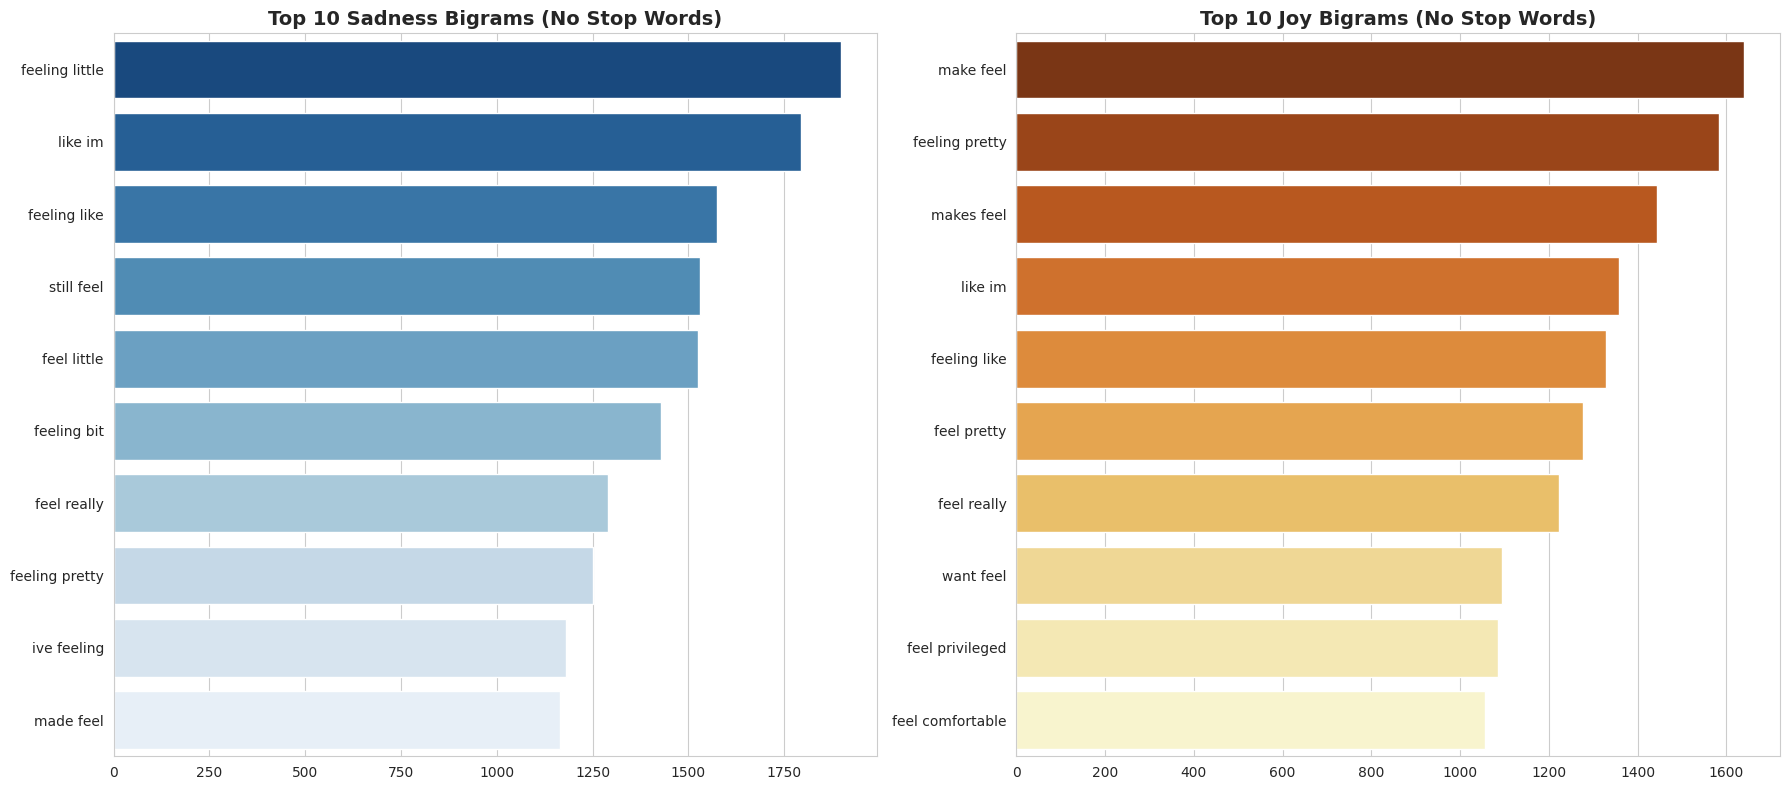

In [209]:
# Process Subsets
# We extract Bigrams (n=2) for both labels
words_bi_sad, freq_bi_sad = get_filtered_ngrams(df_sadness, 2)
words_bi_joy, freq_bi_joy = get_filtered_ngrams(df_joy, 2)

#  Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.set_style("whitegrid")

# --- Left Plot: Sadness ---
sns.barplot(x=freq_bi_sad, y=words_bi_sad, hue=words_bi_sad, palette='Blues_r', ax=axes[0], legend=False)
axes[0].set_title('Top 10 Sadness Bigrams (No Stop Words)', fontsize=14, fontweight='bold')

# --- Right Plot: Joy ---
sns.barplot(x=freq_bi_joy, y=words_bi_joy, hue=words_bi_joy, palette='YlOrBr_r', ax=axes[1], legend=False)
axes[1].set_title('Top 10 Joy Bigrams (No Stop Words)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


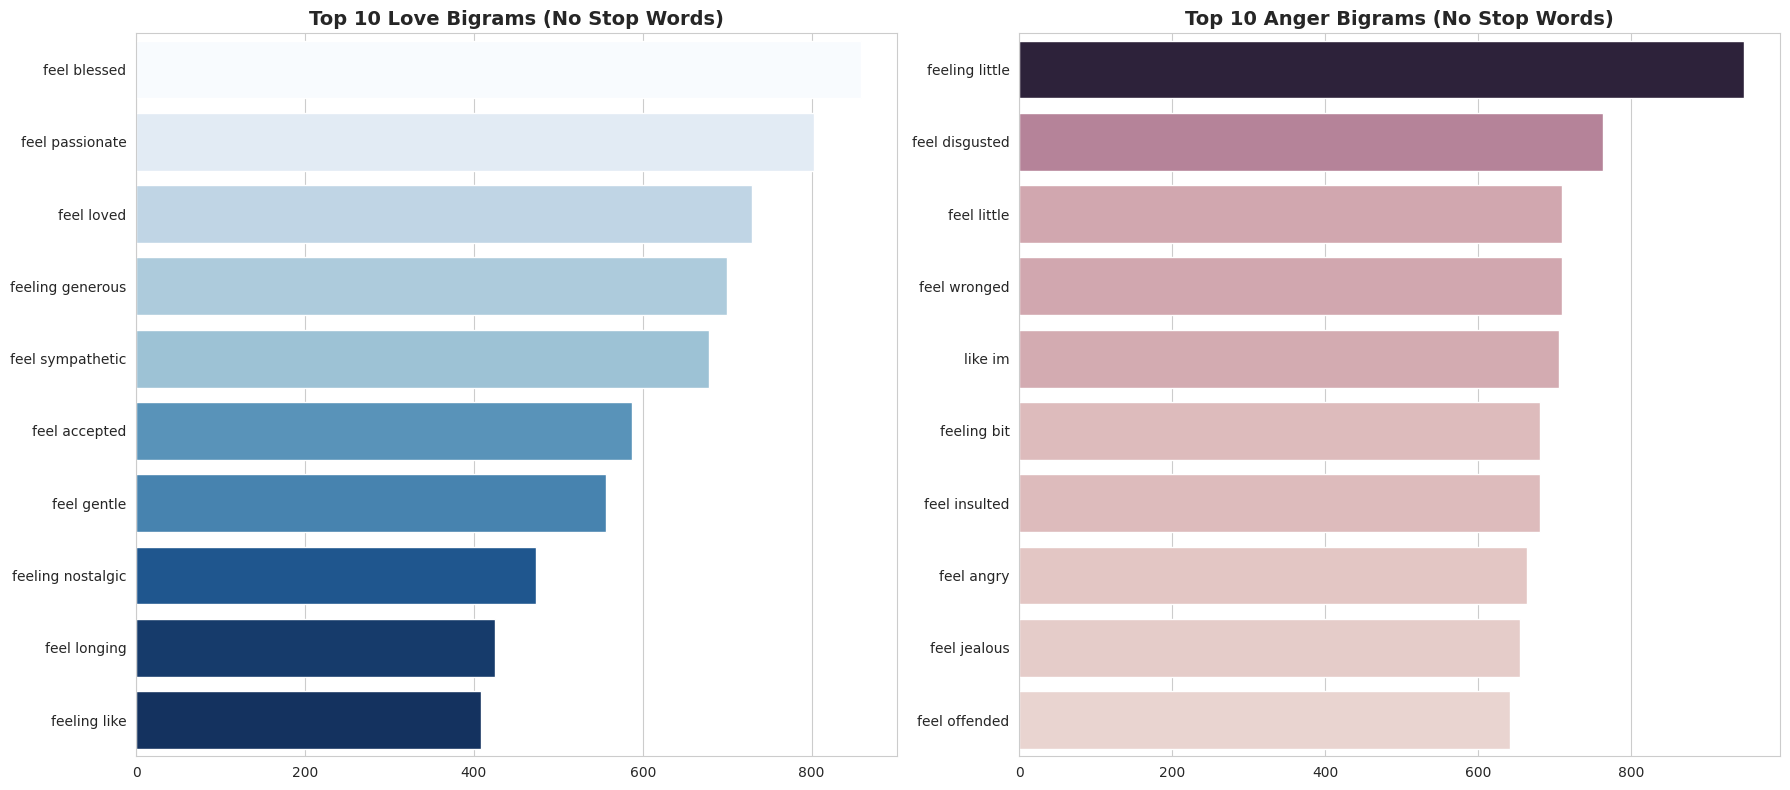

In [210]:
# Process Subsets
# We extract Bigrams (n=2) for both labels
words_bi_love, freq_bi_love = get_filtered_ngrams(df_love, 2)
words_bi_anger, freq_bi_anger = get_filtered_ngrams(df_anger, 2)

#  Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.set_style("whitegrid")

# --- Left Plot: Sadness ---
sns.barplot(y=words_bi_love, x=freq_bi_love, hue=freq_bi_love, palette='Blues_r', ax=axes[0], legend=False)
axes[0].set_title('Top 10 Love Bigrams (No Stop Words)', fontsize=14, fontweight='bold')

# --- Right Plot: Joy ---
sns.barplot(y=words_bi_anger, x=freq_bi_anger, hue=freq_bi_anger, ax=axes[1], legend=False)
axes[1].set_title('Top 10 Anger Bigrams (No Stop Words)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


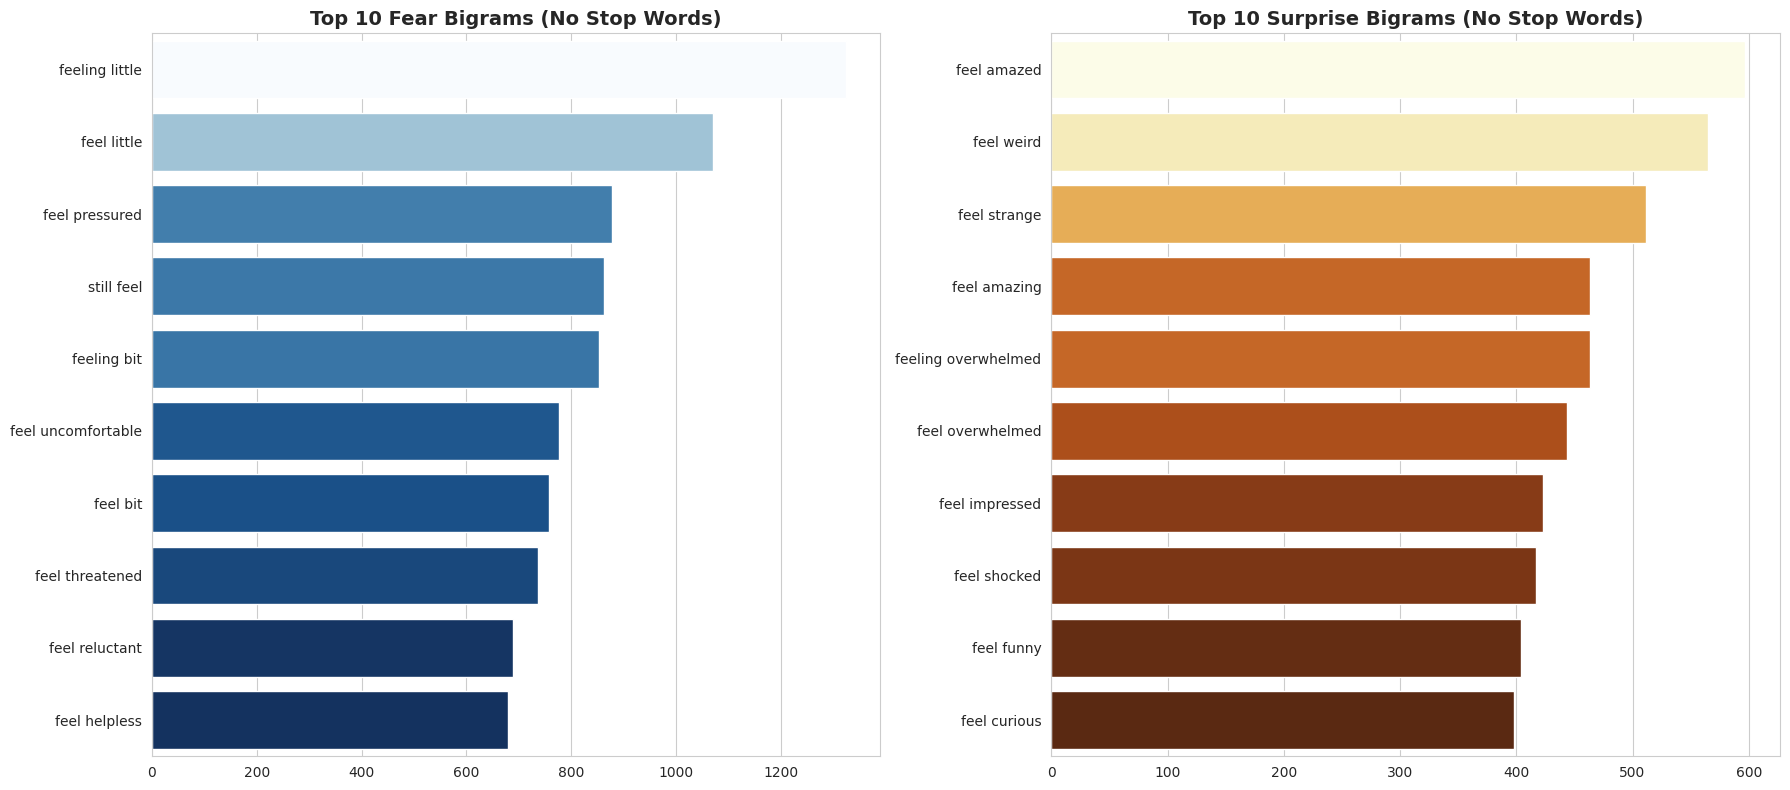

In [211]:
# Process Subsets
# We extract Bigrams (n=2) for both labels
words_bi_fear, freq_bi_fear = get_filtered_ngrams(df_fear, 2)
words_bi_surprise, freq_bi_surprise = get_filtered_ngrams(df_surprise, 2)

#  Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.set_style("whitegrid")

# --- Left Plot: Sadness ---
sns.barplot(y=words_bi_fear, x=freq_bi_fear, hue=freq_bi_fear, palette='Blues_r', ax=axes[0], legend=False)
axes[0].set_title('Top 10 Fear Bigrams (No Stop Words)', fontsize=14, fontweight='bold')

# --- Right Plot: Joy ---
sns.barplot(y=words_bi_surprise, x=freq_bi_surprise, hue=freq_bi_surprise, palette='YlOrBr_r', ax=axes[1], legend=False)
axes[1].set_title('Top 10 Surprise Bigrams (No Stop Words)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

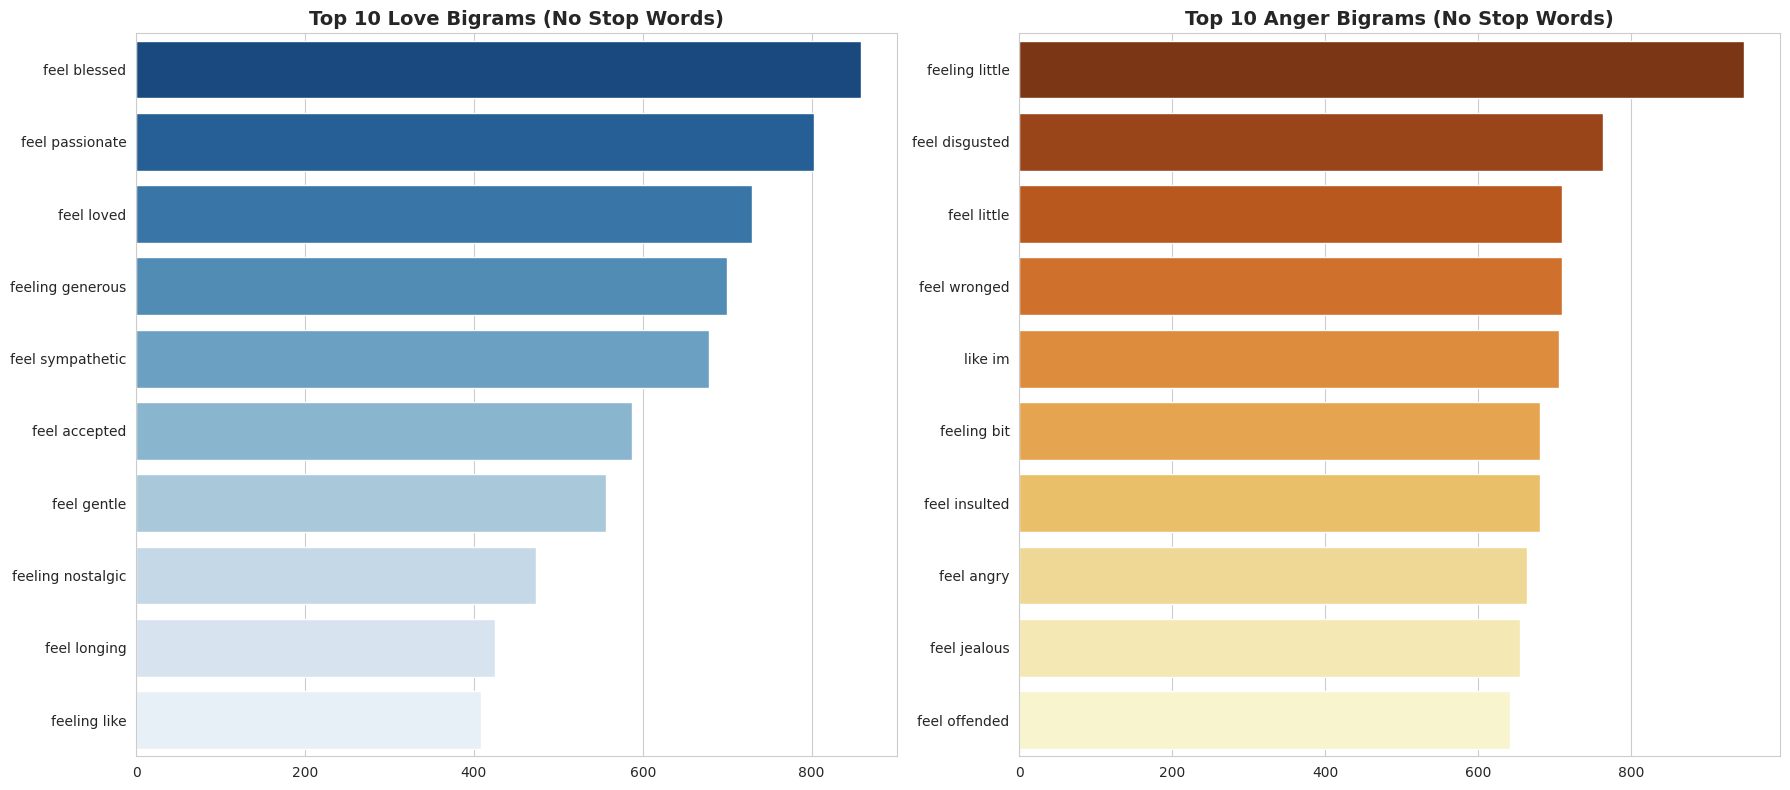

In [212]:
# Process Subsets
# We extract Bigrams (n=2) for both labels
words_bi_love, freq_bi_love = get_filtered_ngrams(df_love, 2)
words_bi_anger, freq_bi_anger = get_filtered_ngrams(df_anger, 2)

#  Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.set_style("whitegrid")

# --- Left Plot: Sadness ---
sns.barplot(x=freq_bi_love, y=words_bi_love, hue=words_bi_love, palette='Blues_r', ax=axes[0], legend=False)
axes[0].set_title('Top 10 Love Bigrams (No Stop Words)', fontsize=14, fontweight='bold')

# --- Right Plot: Joy ---
sns.barplot(x=freq_bi_anger, y=words_bi_anger, hue=words_bi_anger, palette='YlOrBr_r', ax=axes[1], legend=False)
axes[1].set_title('Top 10 Anger Bigrams (No Stop Words)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Data Preprocessing

## Outliers Removal
I will delete only tweets that are on the right side of the distribution, since the distribution is right skeewed.

I choosed

In [178]:
# Remove tweets longer than 6 times the standard deviation + the mean.
outliers_del = int((6*4)*original_std + mean_tweets)
print(f"Outlier delimiter: {outliers_del}")

print(f"Length before filtering: {len(df["text"])}")

filtered_df = df[df['text'].str.len() <= outliers_del]

print(f"Length after filtering: {len(filtered_df["text"])}")
print(f"Difference (deleted samples): {len(df["text"]) - len(filtered_df["text"])}")

Outlier delimiter: 283
Length before filtering: 423056
Length after filtering: 421351
Difference (deleted samples): 1705


In [179]:
filtered_df.describe()

,label_id
count,421351.000000
mean,1.563158
std,1.489933
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,5.000000


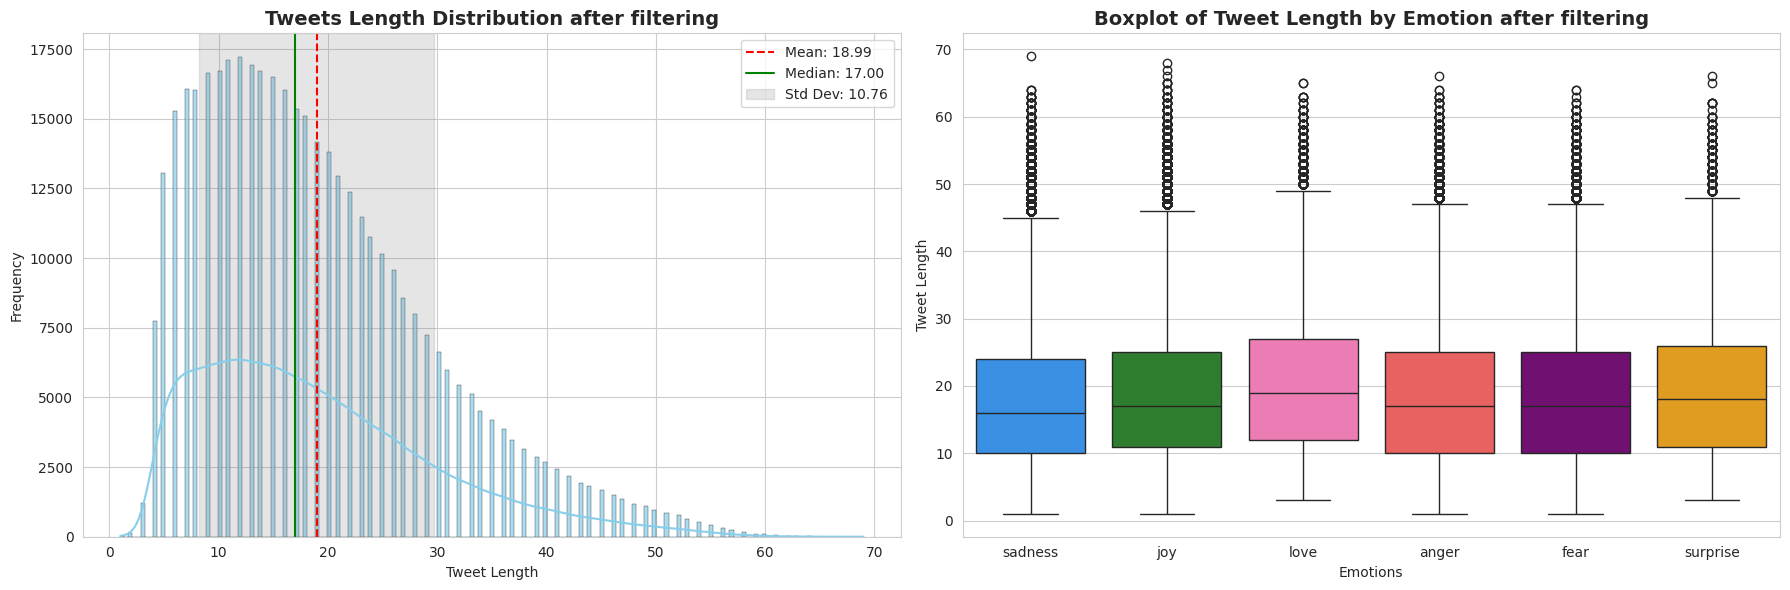

In [180]:
# Extract all words

all_words = []
all_tweets_length = []
for tweet in filtered_df['text']:
  tokens = pipeline.transform(tweet)
  all_words.extend(tokens)
  all_tweets_length.append(len(tokens))

mean_tweets = np.mean(all_tweets_length)
median_tweets = np.median(all_tweets_length)
std_tweets = np.std(all_tweets_length)

# After filtering the graph look like this:

# Create the figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.set_style("whitegrid")

# --- Left Plot: Histogram (Index 0) ---
sns.histplot(all_tweets_length, kde=True, color='skyblue', edgecolor='black', alpha=0.7, ax=axes[0])
axes[0].axvline(mean_tweets, color='red', linestyle='--', label=f'Mean: {mean_tweets:.2f}')
axes[0].axvline(median_tweets, color='green', linestyle='-', label=f'Median: {median_tweets:.2f}')
axes[0].axvspan(mean_tweets - std_tweets, mean_tweets + std_tweets,
                color='grey', alpha=0.2, label=f'Std Dev: {std_tweets:.2f}')
axes[0].set_xlabel('Tweet Length')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Tweets Length Distribution after filtering', fontsize=14, fontweight='bold')
axes[0].legend()

# --- Right Plot: Boxplot (Index 1) ---
sns.boxplot(x="emotions",
            y=all_tweets_length,
            data=filtered_df,
            palette=custom_palette,
            hue='emotions',
            legend=False,
            ax=axes[1]) # This places it in the second slot
axes[1].set_xlabel('Emotions')
axes[1].set_ylabel('Tweet Length')
axes[1].set_title('Boxplot of Tweet Length by Emotion after filtering', fontsize=14, fontweight='bold')

# Automatically adjust spacing
plt.tight_layout()
plt.show()

In [181]:
df = filtered_df

## Create Dictionary


In [182]:
# Create dictionary
# Count unique words in the dataset

# count words
word_counts = Counter(all_words)

print(word_counts)

# This allows you to limit vocab size later if needed
most_common_words = sorted(word_counts, key=word_counts.get, reverse=True)

# Define special tokens
# 0 is usually reserved for padding
word2idx = {"<PAD>": 0, "<UNK>": 1}

# Add unique words from your dataframe starting from index 2
for i, word in enumerate(most_common_words):
    word2idx[word] = i + 2

idx2word = {v: k for k, v in word2idx.items()}

print(f"Unique words found: {len(word2idx)}")

def tweet_to_indices(text, word2idx):
    tokens = pipeline.transform(text)
    return [word2idx.get(token, 1) for token in tokens]

del pipeline
pipeline = PreprocessPipeline()
# Apply to your dataframe
df['sequences'] = df['text'].apply(lambda tweet: tweet_to_indices(tweet, word2idx))

# Clean text
df['text'] = df['text'].apply(lambda tweet: pipeline.clean_text(tweet))

Counter({'i': 673238, 'feel': 288762, 'and': 248514, 'to': 232297, 'the': 216063, 'a': 162879, 'feeling': 133634, 'that': 129828, 'of': 129426, 'my': 110803, 'in': 86183, 'it': 84237, 'like': 73693, 'so': 65096, 'for': 63973, 'im': 61864, 'have': 61113, 'me': 60293, 'but': 58431, 'is': 57688, 'was': 57273, 'this': 54570, 'am': 54293, 'with': 52821, 'not': 47904, 'be': 46772, 'about': 46103, 'on': 40598, 'as': 40597, 'you': 39165, 'just': 37064, 'at': 35867, 'when': 35825, 'or': 33255, 'all': 30945, 'more': 29949, 'because': 29897, 'do': 27770, 'can': 25867, 'really': 25791, 'up': 24417, 't': 23961, 'know': 23709, 'by': 23399, 'are': 23140, 'very': 22955, 'been': 22742, 'out': 22371, 'what': 21602, 'if': 21499, 'myself': 21472, 'time': 21254, 'how': 20081, 'get': 19614, 'little': 19118, 'will': 19029, 'had': 18755, 'now': 18647, 'from': 18459, 'being': 18158, 'people': 18118, 'they': 17989, 'would': 17857, 'he': 16685, 'want': 16412, 'her': 16395, 'one': 16036, 'think': 15820, 'them': 1

/tmp/ipython-input-3745474045.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sequences'] = df['text'].apply(lambda tweet: tweet_to_indices(tweet, word2idx))
/tmp/ipython-input-3745474045.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(lambda tweet: pipeline.clean_text(tweet))


In [183]:
pd.set_option('display.max_colwidth', None)
df.tail(10)

,text,emotions,label_id,sequences
423046,@inthefade going back to blissful ignorance?! #fury,anger,3,"[92, 102, 5, 5343, 3645, 1037, 479, 26409]"
423047,i get discouraged because i try for 5 fucking years a contact with lady gaga but are thousands of tweets how she would see my tweet?,sadness,0,"[2, 55, 535, 38, 2, 203, 16, 9171, 774, 224, 7, 1449, 25, 1394, 9911, 20, 46, 3104, 10, 4738, 54, 98, 64, 112, 11, 3249, 1037]"
423048,watch this amazing live.ly broadcast by @thebrandonrobert #lively #musically,joy,1,"[507, 23, 228, 5395, 4374, 45, 43, 7870, 5442]"
423049,the @orioles are in contention and hosting @redsox nation and camden is empty #sad,sadness,0,"[6, 46, 12, 22666, 4, 5614, 2823, 4, 16205, 21, 466, 4904]"
423050,@msasiapacific @jgsuing @pilosopotanya @huffingtonpost @huffpostpol as a fellow up grad i shiver at the shallowness of his arguments,anger,3,"[30, 7, 1759, 42, 5129, 2, 6470, 33, 6, 30201, 10, 103, 3661]"
423051,.@travelanswerman the possibilities r endless becca when u unplug from the matrix! stay salty and #happy #surfing! #sunset #aloha …,joy,1,"[229, 6, 3476, 2177, 2962, 18895, 34, 856, 16666, 60, 6, 13394, 479, 498, 7691, 4, 4948, 31321, 479, 79718, 42650, 12124]"
423052,you have a #problem? yes! can you do #something about it? no! than why,anger,3,"[31, 18, 7, 31325, 1037, 858, 479, 40, 31, 39, 79719, 28, 13, 1037, 95, 479, 94, 153]"
423053,@andreamitchell said @berniesanders not only did not play up hrc in campaigning 4 her in oh but he did not discourage 3rd party vote. true??,surprise,5,"[192, 26, 115, 122, 26, 608, 42, 26354, 12, 15619, 7034, 67, 12, 724, 20, 65, 122, 26, 6155, 19112, 1033, 2456, 229, 764, 1037, 1037]"
423054,@isthataspider @dhodgs i will fight this guy! dont insult the lions like that! but seriously they kinda are.wasted some of the best players,anger,3,"[2, 57, 1120, 23, 547, 479, 88, 3614, 6, 9023, 14, 9, 479, 20, 952, 63, 480, 79720, 72, 10, 6, 302, 2227]"
423055,i wonder how a guy can broke his penis while having sex? #serious,surprise,5,"[2, 639, 54, 7, 547, 40, 624, 103, 6598, 187, 150, 1005, 1037, 8551]"


# Model Architecture

In [208]:
class EmotionClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, glove_weights):
        super(EmotionClassifier, self).__init__()

        # Define the embedding layer
        self.embedding = nn.Embedding.from_pretrained(
            glove_weights,
            freeze=False  # Set to True if you don't want to fine-tune the embeddings
        )

        # Example Bi-LSTM setup following the embedding
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, text):
        # text shape: [batch_size, seq_len]
        embedded = self.embedding(text)
        # embedded shape: [batch_size, seq_len, embedding_dim]

        output, (hidden, cell) = self.lstm(embedded)

        # Concatenate the final forward and backward hidden states
        hidden_cat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)

        return self.fc(hidden_cat)

# Training Pipeline

In [209]:
# Divide dataset into train and test

from sklearn.model_selection import train_test_split
# x = your sequences (list of lists of integers)
# y = your labels (0 to 5)
train_sequences, test_sequences, train_labels, test_labels = train_test_split(
    df['sequences'].values,
    df['label_id'].values,
    test_size=0.2,          # 20% for testing
    random_state=42,        # For reproducibility
    stratify=df['label_id'].values
)

In [210]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class EmoDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = [torch.tensor(s) for s in sequences]
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [211]:
def collate_fn(batch):
    # Sort by length (optional but helps LSTM efficiency)
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    sequences, labels = zip(*batch)

    # Pad sequences to the length of the longest one in this batch
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    labels = torch.stack(labels)

    return padded_sequences, labels

# Create the final DataLoaders
train_loader = DataLoader(
    EmoDataset(train_sequences, train_labels),
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    EmoDataset(test_sequences, test_labels),
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn
)

In [212]:
# Create obj glove weight matrix and model
weights = load_glove_embeddings('glove.6B.100d.txt', word2idx)
model = EmotionClassifier(len(word2idx), 100, 256, 6, weights)

In [213]:
# Hyperparameters
LEARNING_RATE = 0.001
EPOCH_NUM = 10

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [214]:
# Training Loop
for epoch in range(EPOCH_NUM):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        # Cast labels to long (int64) which is required by CrossEntropyLoss
        inputs, labels = inputs.to(device), labels.to(device).long()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    # Validation Loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Cast labels to long for validation as well
            inputs, labels = inputs.to(device), labels.to(device).long()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_loss / len(test_loader)
    val_acc = 100 * correct_val / total_val

    print(f'Epoch [{epoch+1}/{EPOCH_NUM}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

KeyboardInterrupt: 

# Evaluation and Metrics

# Inference Testing

In [ ]:
# Switch model to evaluation mode
model.eval()

# Select a random tweet from the dataset
random_row = df.sample(1).iloc[0]
tweet = random_row['text']
true_label = random_row['emotions']

# Preprocess the tweet
indices = tweet_to_indices(tweet, word2idx)

# Convert to tensor and add batch dimension (batch_size=1)
input_tensor = torch.tensor(indices).unsqueeze(0).to(device)

# Perform inference
with torch.no_grad():
    output = model(input_tensor)
    predicted_idx = torch.argmax(output, dim=1).item()
    # Use emotion_to_id which maps int -> string (variable names were swapped in definition)
    predicted_label = emotion_to_id[predicted_idx]

# Display results
print(f"Tweet: {tweet}")
print(f"True Emotion: {true_label}")
print(f"Predicted Emotion: {predicted_label}")